In [19]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from tqdm import tqdm
import xgboost as xgb #BDT
import pickle
import mplhep as hep

import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from utils.analysis import Optimization

TAG = "new_signal"

In [20]:
babies = sorted(glob.glob(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/*.root"))
sig_babies = [baby for baby in babies if "VBSVVH" in baby]
bkg_babies = [baby for baby in babies if "VBS" not in baby and "data" not in baby]
data_babies = [baby for baby in babies if "data" in baby]
print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:
../analysis/studies/vbsvvhjets/output_new_signal/Run2/VBSVVH.root
Background:
../analysis/studies/vbsvvhjets/output_new_signal/Run2/Bosons.root
../analysis/studies/vbsvvhjets/output_new_signal/Run2/QCD.root
../analysis/studies/vbsvvhjets/output_new_signal/Run2/SingleTop.root
../analysis/studies/vbsvvhjets/output_new_signal/Run2/TT1L.root
../analysis/studies/vbsvvhjets/output_new_signal/Run2/TTH.root
../analysis/studies/vbsvvhjets/output_new_signal/Run2/TTHad.root
../analysis/studies/vbsvvhjets/output_new_signal/Run2/TTW.root
Data:
../analysis/studies/vbsvvhjets/output_new_signal/Run2/data.root


In [21]:
vbsvvh = Optimization(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf",
        "prefire_sf"
    ]
)
vbsvvh.df["objsel"] = True
vbsvvh.df["presel"] = vbsvvh.df.eval(
    "objsel and hbbfatjet_xbb > 0.5 and ld_vqqfatjet_xwqq > 0.3 and tr_vqqfatjet_xwqq > 0.3"
)
vbsvvh.make_selection("presel")

bkg_count = vbsvvh.bkg_count()
qcd_count = vbsvvh.sample_count("QCD")
data_count = vbsvvh.data_count()

vbsvvh.df.loc[vbsvvh.df.name == "QCD", "event_weight"] *= (data_count - (bkg_count - qcd_count))/(qcd_count)

Loading data babies: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


In [22]:
# vbsvvh.df["bdt_presel"] = vbsvvh.df.eval(
#     "M_jj > 500 and abs(deta_jj) > 3"
#     + "and hbbfatjet_xbb > 0.5"
#     + "and ld_vqqfatjet_xwqq > 0.5 and tr_vqqfatjet_xwqq > 0.5"
#     + "and ST > 1300"
#     + "and hbbfatjet_mass < 150"
#     + "and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
# )
# vbsvvh.df["bdt_presel"] = vbsvvh.df.eval(
#     "ST > 1300"
#     + " and hbbfatjet_xbb > 0.5"
#     + " and hbbfatjet_mass < 150"
#     + " and ld_vqqfatjet_xwqq > 0.5 and tr_vqqfatjet_xwqq > 0.5"
#     + " and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
# )
# vbsvvh.sig_count(selection="bdt_presel")

In [23]:
vbsvvh.sample_df("TTHad").event_weight.sum()

1455.786746361521

In [24]:
vbsvvh.sample_df("QCD").event_weight.sum()

12155.007170808372

In [25]:
vbsvvh.sig_count()

11.290898847789581

In [26]:
print("\n".join(vbsvvh.df.columns))

reweight_c2v_eq_3
HT
n_jets
n_loose_b_jets
n_medium_b_jets
n_tight_b_jets
btag_sf
btag_sf_up
btag_sf_dn
puid_sf
puid_sf_up
puid_sf_dn
HT_fat
n_fatjets
ld_vbsjet_pt
ld_vbsjet_eta
ld_vbsjet_phi
tr_vbsjet_pt
tr_vbsjet_eta
tr_vbsjet_phi
M_jj
pt_jj
eta_jj
phi_jj
deta_jj
abs_deta_jj
dR_jj
xsec_sf
pu_sf
pu_sf_up
pu_sf_dn
prefire_sf
prefire_sf_up
prefire_sf_dn
trig_sf
trig_sf_up
trig_sf_dn
event
year
MET
MET_up
MET_dn
lhe_muF0p5_muR0p5
lhe_muF1p0_muR0p5
lhe_muF2p0_muR0p5
lhe_muF0p5_muR1p0
lhe_muF1p0_muR1p0
lhe_muF2p0_muR1p0
lhe_muF0p5_muR2p0
lhe_muF1p0_muR2p0
lhe_muF2p0_muR2p0
ps_isr2p0_fsr1p0
ps_isr1p0_fsr2p0
ps_isr0p5_fsr1p0
ps_isr1p0_fsr0p5
ld_vqqfatjet_xwqq
ld_vqqfatjet_xvqq
ld_vqqfatjet_pt
ld_vqqfatjet_eta
ld_vqqfatjet_phi
ld_vqqfatjet_mass
ld_vqqfatjet_msoftdrop
tr_vqqfatjet_xwqq
tr_vqqfatjet_xvqq
tr_vqqfatjet_pt
tr_vqqfatjet_eta
tr_vqqfatjet_phi
tr_vqqfatjet_mass
tr_vqqfatjet_msoftdrop
ld_vqqjet_qgl
ld_vqqjet_pt
ld_vqqjet_eta
ld_vqqjet_phi
ld_vqqjet_mass
tr_vqqjet_qgl
tr_vqqjet_pt
tr_vq

In [27]:
vbsvvh.df["ld_vbsjet_eta_sq"] = vbsvvh.df.ld_vbsjet_eta**2
vbsvvh.df["tr_vbsjet_eta_sq"] = vbsvvh.df.tr_vbsjet_eta**2

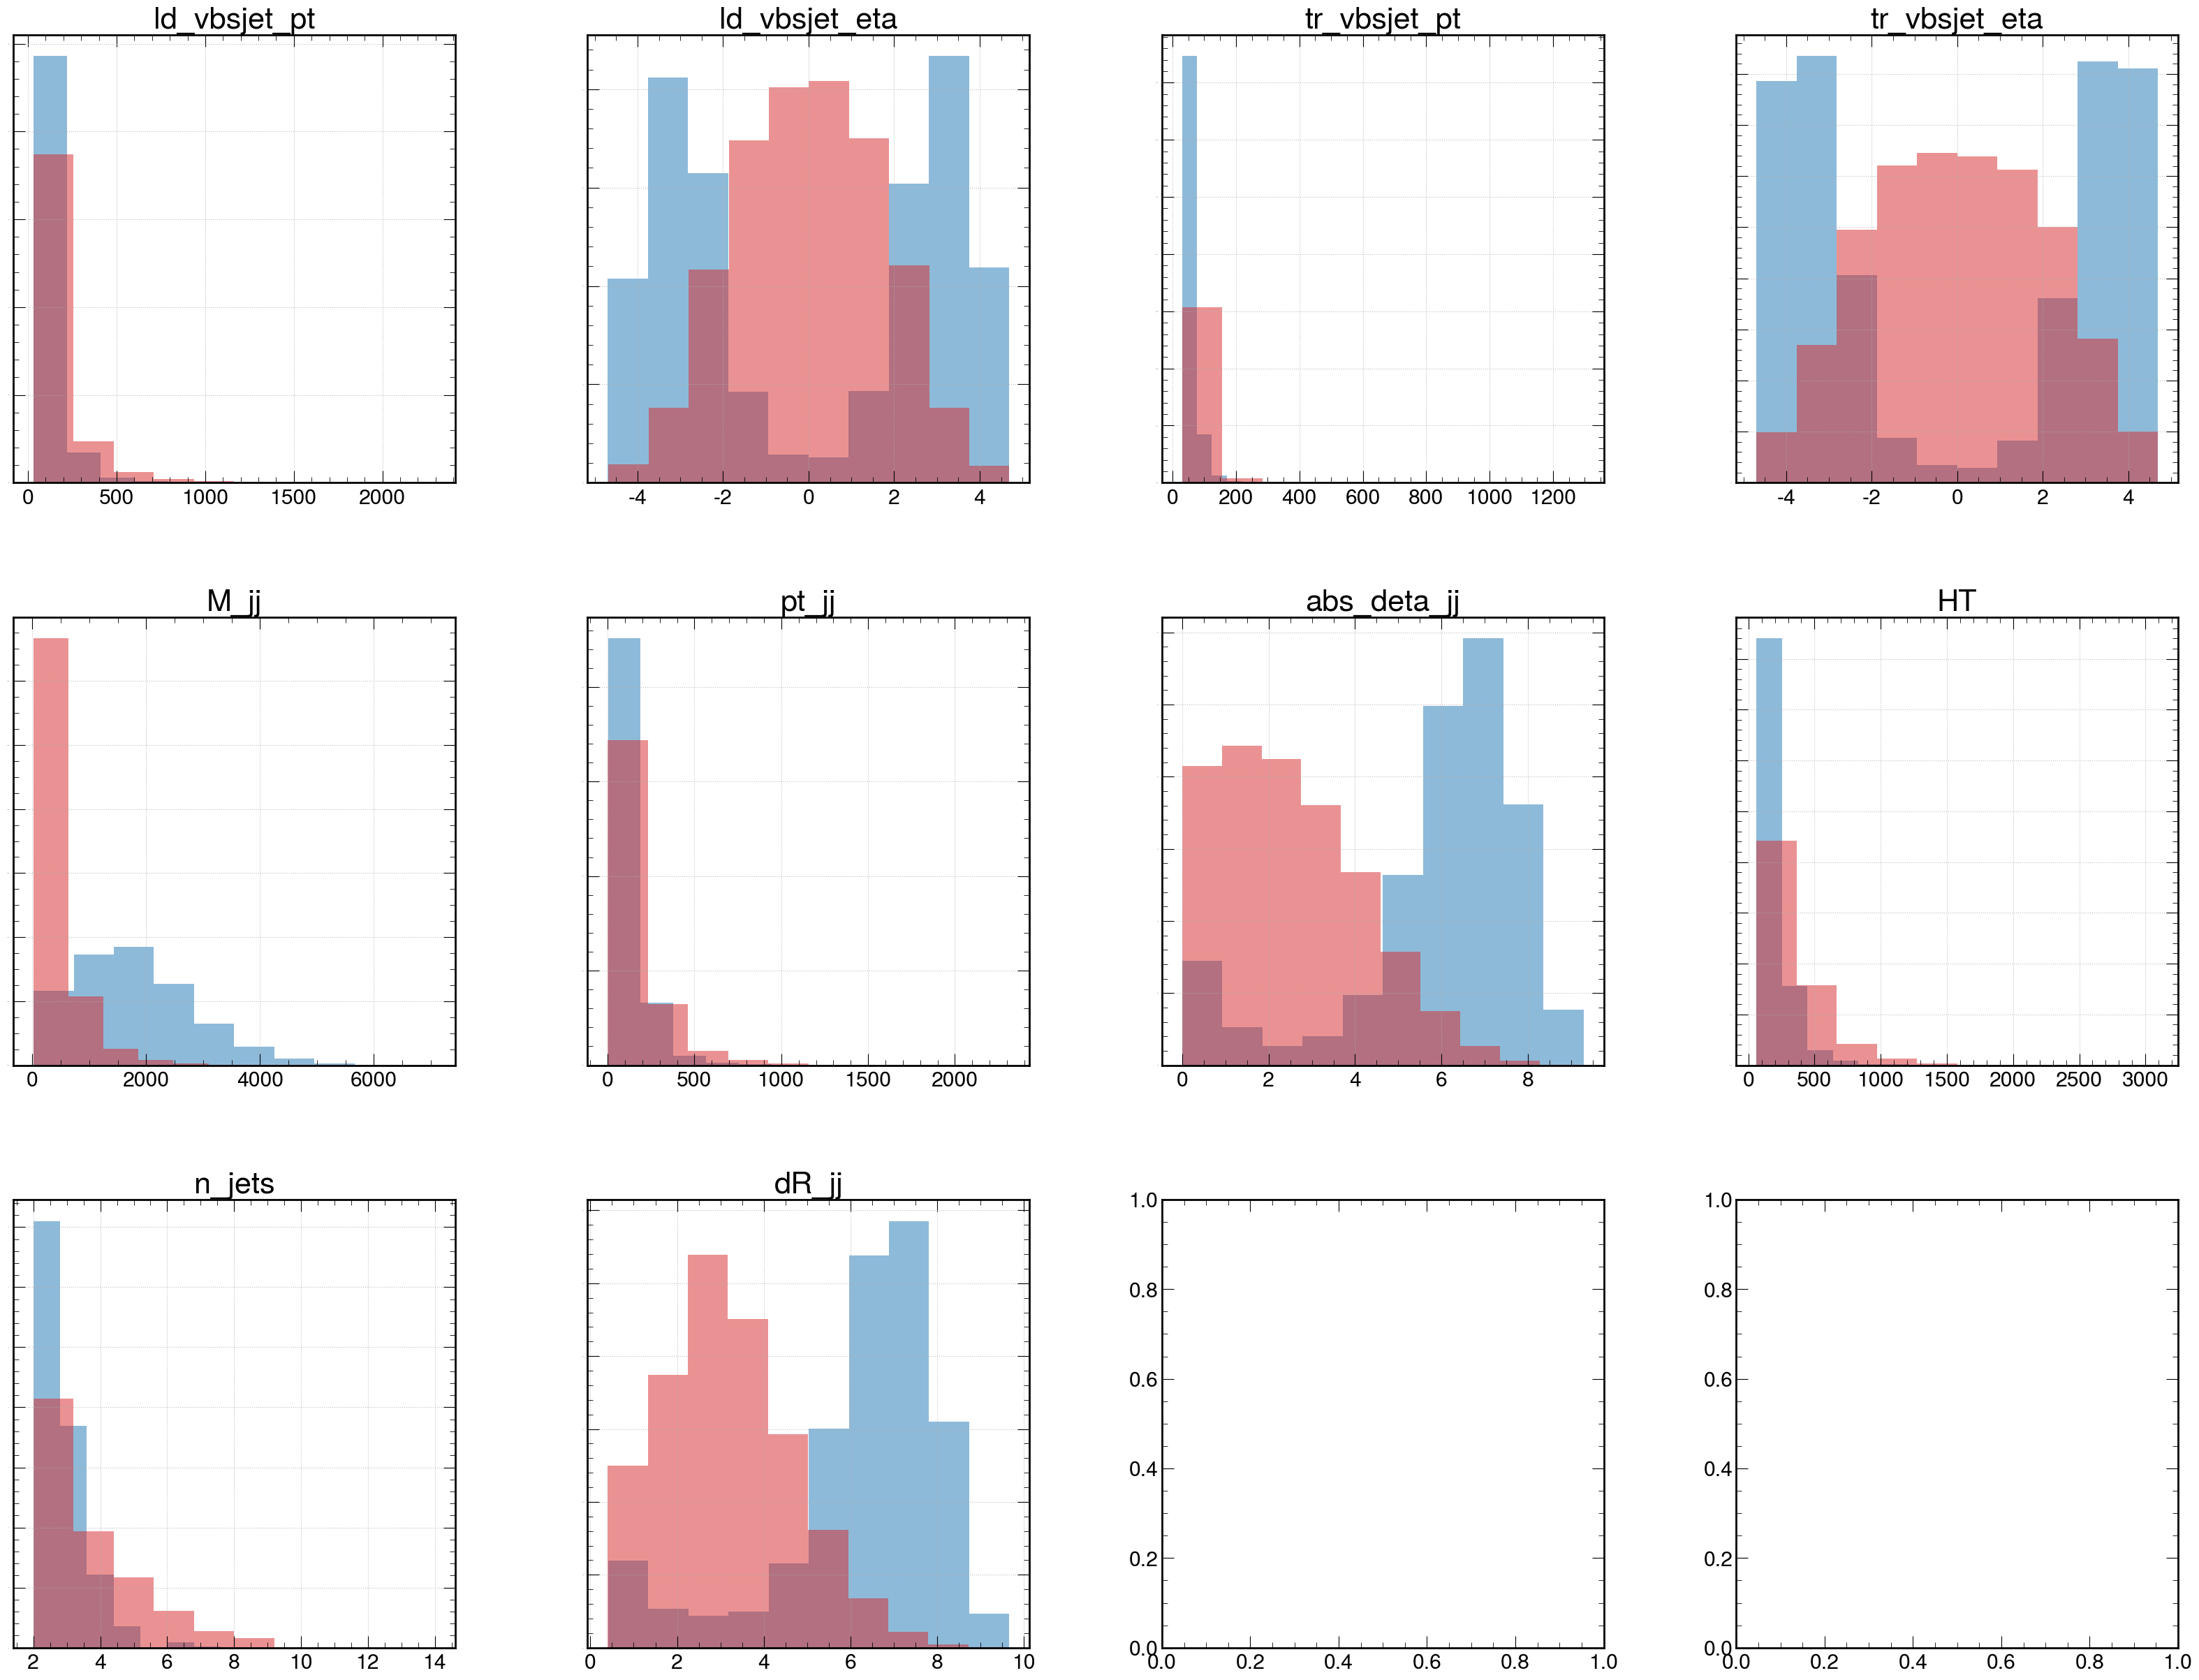

In [28]:
# Select features
features = [
#     "ld_vqqfatjet_score",
#     "tr_vqqfatjet_score",
#     "hbbfatjet_score",
#     "ld_vqqfatjet_mass",
#     "tr_vqqfatjet_mass",
#     "hbbfatjet_mass",
#     "ST",
#     "ld_vqqfatjet_pt",
#     "tr_vqqfatjet_pt", 
#     "hbbfatjet_pt",
#     "VVH_pt"
    "ld_vbsjet_pt",
    "ld_vbsjet_eta",
#     "ld_vbsjet_phi",
    "tr_vbsjet_pt",
    "tr_vbsjet_eta",
#     "tr_vbsjet_phi",
    "M_jj",
    "pt_jj",
    "abs_deta_jj",
    "HT",
    "n_jets",
    "dR_jj"
]

# Plot feature shapes
fig, axes = plt.subplots(3,4,figsize=(40,30))

sig_df = vbsvvh.sig_df()
bkg_df = vbsvvh.bkg_df()

ax = sig_df[features].hist(
    ax=axes.flatten()[:len(features)],
    alpha=0.5, color="C0", ylabelsize=0, 
    density=True
)
ax = bkg_df[features].hist(
    ax=axes.flatten()[:len(features)], 
    alpha=0.5, color="C3", ylabelsize=0, 
    density=True
)

In [29]:
vbsvvh.set_split_column(ratio=0.6, name="split")

train_df = vbsvvh.df[vbsvvh.df.split].sample(frac=1.)
test_df = vbsvvh.df[~vbsvvh.df.split].sample(frac=1.)

# BDT input
dtest = xgb.DMatrix(
    test_df[features], 
    label=test_df.is_signal,
    weight=np.abs(test_df.split_weight)
)
dtrain = xgb.DMatrix(
    train_df[features], 
    label=train_df.is_signal, 
    weight=np.abs(train_df.split_weight)
)
evallist = [(dtrain, "train"), (dtest, "eval")]

# BDT parameters setup
params = {}
params["objective"] = "binary:logistic"

# BDT knobs (hyper-parameters)
num_round = 3000                  # Number of training rounds
params["eta"] = 0.01              # Step size shrinkage (alias: learning_rate)
params["max_depth"] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
params["verbosity"] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
params["nthread"] = 8            # Number of parallel threads
params["eval_metric"] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the [ROC] Curve
params["subsample"] = 0.6        # Subsample ratio of the training instances
params["alpha"] = 4.0            # L1 regularization term on weights: Larger = more conservative
params["gamma"] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
params["lambda"] = 1.0           # L2 regularization term on weights: Larger = more conservative
params["min_child_weight"] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
params["colsample_bytree"] = 1.0 # The subsample ratio of columns when constructing each tree
# params["base_score"] = 0.1       # The initial prediction score of all instances, global bias

# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label() == 1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label() == 0]).sum()
# Control the balance of positive and negative weights, useful for unbalanced classes
# A typical value to consider: sum(negative instances) / sum(positive instances)
params["scale_pos_weight"] = sumw_neg/sumw_pos

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [30]:
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=1000, verbose_eval=True)

[0]	train-auc:0.91054	eval-auc:0.90940
[1]	train-auc:0.93325	eval-auc:0.92910
[2]	train-auc:0.93554	eval-auc:0.93154
[3]	train-auc:0.93950	eval-auc:0.93522
[4]	train-auc:0.93991	eval-auc:0.93619
[5]	train-auc:0.94017	eval-auc:0.93617
[6]	train-auc:0.93999	eval-auc:0.93606
[7]	train-auc:0.93973	eval-auc:0.93588
[8]	train-auc:0.94149	eval-auc:0.93796
[9]	train-auc:0.94185	eval-auc:0.93848
[10]	train-auc:0.94270	eval-auc:0.93984
[11]	train-auc:0.94342	eval-auc:0.94022
[12]	train-auc:0.94372	eval-auc:0.94095
[13]	train-auc:0.94343	eval-auc:0.94050
[14]	train-auc:0.94527	eval-auc:0.94246
[15]	train-auc:0.94781	eval-auc:0.94567
[16]	train-auc:0.94847	eval-auc:0.94650
[17]	train-auc:0.94834	eval-auc:0.94633
[18]	train-auc:0.94856	eval-auc:0.94657
[19]	train-auc:0.94871	eval-auc:0.94661
[20]	train-auc:0.94929	eval-auc:0.94752
[21]	train-auc:0.94920	eval-auc:0.94746
[22]	train-auc:0.94936	eval-auc:0.94757
[23]	train-auc:0.94913	eval-auc:0.94733
[24]	train-auc:0.94913	eval-auc:0.94741
[25]	train

[203]	train-auc:0.96104	eval-auc:0.95960
[204]	train-auc:0.96105	eval-auc:0.95958
[205]	train-auc:0.96108	eval-auc:0.95960
[206]	train-auc:0.96110	eval-auc:0.95962
[207]	train-auc:0.96111	eval-auc:0.95963
[208]	train-auc:0.96115	eval-auc:0.95970
[209]	train-auc:0.96118	eval-auc:0.95971
[210]	train-auc:0.96120	eval-auc:0.95973
[211]	train-auc:0.96126	eval-auc:0.95977
[212]	train-auc:0.96128	eval-auc:0.95984
[213]	train-auc:0.96132	eval-auc:0.95987
[214]	train-auc:0.96133	eval-auc:0.95990
[215]	train-auc:0.96141	eval-auc:0.95999
[216]	train-auc:0.96143	eval-auc:0.96001
[217]	train-auc:0.96147	eval-auc:0.96005
[218]	train-auc:0.96151	eval-auc:0.96009
[219]	train-auc:0.96151	eval-auc:0.96008
[220]	train-auc:0.96150	eval-auc:0.96007
[221]	train-auc:0.96152	eval-auc:0.96009
[222]	train-auc:0.96155	eval-auc:0.96012
[223]	train-auc:0.96159	eval-auc:0.96013
[224]	train-auc:0.96161	eval-auc:0.96015
[225]	train-auc:0.96164	eval-auc:0.96020
[226]	train-auc:0.96167	eval-auc:0.96024
[227]	train-auc:

[403]	train-auc:0.96524	eval-auc:0.96369
[404]	train-auc:0.96526	eval-auc:0.96371
[405]	train-auc:0.96529	eval-auc:0.96373
[406]	train-auc:0.96530	eval-auc:0.96375
[407]	train-auc:0.96530	eval-auc:0.96374
[408]	train-auc:0.96533	eval-auc:0.96377
[409]	train-auc:0.96535	eval-auc:0.96380
[410]	train-auc:0.96536	eval-auc:0.96382
[411]	train-auc:0.96537	eval-auc:0.96382
[412]	train-auc:0.96539	eval-auc:0.96383
[413]	train-auc:0.96540	eval-auc:0.96384
[414]	train-auc:0.96542	eval-auc:0.96385
[415]	train-auc:0.96544	eval-auc:0.96386
[416]	train-auc:0.96545	eval-auc:0.96387
[417]	train-auc:0.96547	eval-auc:0.96388
[418]	train-auc:0.96548	eval-auc:0.96389
[419]	train-auc:0.96549	eval-auc:0.96392
[420]	train-auc:0.96552	eval-auc:0.96394
[421]	train-auc:0.96555	eval-auc:0.96396
[422]	train-auc:0.96556	eval-auc:0.96397
[423]	train-auc:0.96558	eval-auc:0.96398
[424]	train-auc:0.96560	eval-auc:0.96399
[425]	train-auc:0.96560	eval-auc:0.96399
[426]	train-auc:0.96561	eval-auc:0.96398
[427]	train-auc:

[603]	train-auc:0.96771	eval-auc:0.96551
[604]	train-auc:0.96773	eval-auc:0.96552
[605]	train-auc:0.96774	eval-auc:0.96553
[606]	train-auc:0.96775	eval-auc:0.96554
[607]	train-auc:0.96776	eval-auc:0.96555
[608]	train-auc:0.96776	eval-auc:0.96555
[609]	train-auc:0.96777	eval-auc:0.96555
[610]	train-auc:0.96778	eval-auc:0.96556
[611]	train-auc:0.96781	eval-auc:0.96557
[612]	train-auc:0.96781	eval-auc:0.96558
[613]	train-auc:0.96782	eval-auc:0.96558
[614]	train-auc:0.96782	eval-auc:0.96558
[615]	train-auc:0.96784	eval-auc:0.96558
[616]	train-auc:0.96784	eval-auc:0.96558
[617]	train-auc:0.96785	eval-auc:0.96559
[618]	train-auc:0.96786	eval-auc:0.96560
[619]	train-auc:0.96787	eval-auc:0.96560
[620]	train-auc:0.96788	eval-auc:0.96561
[621]	train-auc:0.96789	eval-auc:0.96561
[622]	train-auc:0.96790	eval-auc:0.96563
[623]	train-auc:0.96791	eval-auc:0.96563
[624]	train-auc:0.96792	eval-auc:0.96564
[625]	train-auc:0.96792	eval-auc:0.96564
[626]	train-auc:0.96793	eval-auc:0.96564
[627]	train-auc:

[803]	train-auc:0.96916	eval-auc:0.96611
[804]	train-auc:0.96917	eval-auc:0.96612
[805]	train-auc:0.96918	eval-auc:0.96612
[806]	train-auc:0.96918	eval-auc:0.96612
[807]	train-auc:0.96919	eval-auc:0.96612
[808]	train-auc:0.96920	eval-auc:0.96613
[809]	train-auc:0.96920	eval-auc:0.96614
[810]	train-auc:0.96921	eval-auc:0.96614
[811]	train-auc:0.96922	eval-auc:0.96615
[812]	train-auc:0.96922	eval-auc:0.96614
[813]	train-auc:0.96923	eval-auc:0.96615
[814]	train-auc:0.96923	eval-auc:0.96614
[815]	train-auc:0.96924	eval-auc:0.96614
[816]	train-auc:0.96925	eval-auc:0.96615
[817]	train-auc:0.96925	eval-auc:0.96615
[818]	train-auc:0.96925	eval-auc:0.96615
[819]	train-auc:0.96926	eval-auc:0.96615
[820]	train-auc:0.96927	eval-auc:0.96615
[821]	train-auc:0.96927	eval-auc:0.96615
[822]	train-auc:0.96928	eval-auc:0.96615
[823]	train-auc:0.96928	eval-auc:0.96616
[824]	train-auc:0.96929	eval-auc:0.96616
[825]	train-auc:0.96929	eval-auc:0.96616
[826]	train-auc:0.96930	eval-auc:0.96616
[827]	train-auc:

[1003]	train-auc:0.97023	eval-auc:0.96645
[1004]	train-auc:0.97023	eval-auc:0.96645
[1005]	train-auc:0.97024	eval-auc:0.96645
[1006]	train-auc:0.97025	eval-auc:0.96645
[1007]	train-auc:0.97025	eval-auc:0.96645
[1008]	train-auc:0.97026	eval-auc:0.96645
[1009]	train-auc:0.97027	eval-auc:0.96645
[1010]	train-auc:0.97027	eval-auc:0.96646
[1011]	train-auc:0.97028	eval-auc:0.96646
[1012]	train-auc:0.97029	eval-auc:0.96646
[1013]	train-auc:0.97029	eval-auc:0.96646
[1014]	train-auc:0.97029	eval-auc:0.96647
[1015]	train-auc:0.97030	eval-auc:0.96647
[1016]	train-auc:0.97030	eval-auc:0.96648
[1017]	train-auc:0.97030	eval-auc:0.96647
[1018]	train-auc:0.97030	eval-auc:0.96648
[1019]	train-auc:0.97031	eval-auc:0.96648
[1020]	train-auc:0.97032	eval-auc:0.96648
[1021]	train-auc:0.97032	eval-auc:0.96649
[1022]	train-auc:0.97033	eval-auc:0.96649
[1023]	train-auc:0.97033	eval-auc:0.96649
[1024]	train-auc:0.97033	eval-auc:0.96649
[1025]	train-auc:0.97034	eval-auc:0.96649
[1026]	train-auc:0.97035	eval-auc:

[1199]	train-auc:0.97116	eval-auc:0.96664
[1200]	train-auc:0.97116	eval-auc:0.96665
[1201]	train-auc:0.97117	eval-auc:0.96665
[1202]	train-auc:0.97117	eval-auc:0.96665
[1203]	train-auc:0.97117	eval-auc:0.96665
[1204]	train-auc:0.97118	eval-auc:0.96665
[1205]	train-auc:0.97118	eval-auc:0.96665
[1206]	train-auc:0.97118	eval-auc:0.96665
[1207]	train-auc:0.97119	eval-auc:0.96665
[1208]	train-auc:0.97119	eval-auc:0.96665
[1209]	train-auc:0.97120	eval-auc:0.96665
[1210]	train-auc:0.97120	eval-auc:0.96665
[1211]	train-auc:0.97120	eval-auc:0.96665
[1212]	train-auc:0.97120	eval-auc:0.96666
[1213]	train-auc:0.97121	eval-auc:0.96666
[1214]	train-auc:0.97121	eval-auc:0.96666
[1215]	train-auc:0.97122	eval-auc:0.96666
[1216]	train-auc:0.97122	eval-auc:0.96666
[1217]	train-auc:0.97123	eval-auc:0.96666
[1218]	train-auc:0.97123	eval-auc:0.96666
[1219]	train-auc:0.97124	eval-auc:0.96666
[1220]	train-auc:0.97124	eval-auc:0.96666
[1221]	train-auc:0.97124	eval-auc:0.96666
[1222]	train-auc:0.97125	eval-auc:

[1395]	train-auc:0.97195	eval-auc:0.96681
[1396]	train-auc:0.97196	eval-auc:0.96681
[1397]	train-auc:0.97196	eval-auc:0.96681
[1398]	train-auc:0.97197	eval-auc:0.96681
[1399]	train-auc:0.97197	eval-auc:0.96681
[1400]	train-auc:0.97198	eval-auc:0.96681
[1401]	train-auc:0.97198	eval-auc:0.96681
[1402]	train-auc:0.97198	eval-auc:0.96682
[1403]	train-auc:0.97199	eval-auc:0.96682
[1404]	train-auc:0.97199	eval-auc:0.96682
[1405]	train-auc:0.97199	eval-auc:0.96682
[1406]	train-auc:0.97199	eval-auc:0.96682
[1407]	train-auc:0.97200	eval-auc:0.96681
[1408]	train-auc:0.97200	eval-auc:0.96682
[1409]	train-auc:0.97201	eval-auc:0.96682
[1410]	train-auc:0.97202	eval-auc:0.96682
[1411]	train-auc:0.97202	eval-auc:0.96682
[1412]	train-auc:0.97202	eval-auc:0.96682
[1413]	train-auc:0.97203	eval-auc:0.96682
[1414]	train-auc:0.97203	eval-auc:0.96682
[1415]	train-auc:0.97204	eval-auc:0.96683
[1416]	train-auc:0.97205	eval-auc:0.96683
[1417]	train-auc:0.97205	eval-auc:0.96683
[1418]	train-auc:0.97205	eval-auc:

[1591]	train-auc:0.97271	eval-auc:0.96686
[1592]	train-auc:0.97272	eval-auc:0.96686
[1593]	train-auc:0.97272	eval-auc:0.96686
[1594]	train-auc:0.97273	eval-auc:0.96686
[1595]	train-auc:0.97273	eval-auc:0.96686
[1596]	train-auc:0.97274	eval-auc:0.96686
[1597]	train-auc:0.97274	eval-auc:0.96686
[1598]	train-auc:0.97274	eval-auc:0.96686
[1599]	train-auc:0.97275	eval-auc:0.96686
[1600]	train-auc:0.97276	eval-auc:0.96685
[1601]	train-auc:0.97276	eval-auc:0.96685
[1602]	train-auc:0.97276	eval-auc:0.96685
[1603]	train-auc:0.97276	eval-auc:0.96685
[1604]	train-auc:0.97277	eval-auc:0.96685
[1605]	train-auc:0.97278	eval-auc:0.96685
[1606]	train-auc:0.97278	eval-auc:0.96685
[1607]	train-auc:0.97278	eval-auc:0.96685
[1608]	train-auc:0.97278	eval-auc:0.96685
[1609]	train-auc:0.97279	eval-auc:0.96685
[1610]	train-auc:0.97279	eval-auc:0.96685
[1611]	train-auc:0.97279	eval-auc:0.96685
[1612]	train-auc:0.97280	eval-auc:0.96685
[1613]	train-auc:0.97280	eval-auc:0.96685
[1614]	train-auc:0.97280	eval-auc:

[1787]	train-auc:0.97340	eval-auc:0.96691
[1788]	train-auc:0.97341	eval-auc:0.96691
[1789]	train-auc:0.97341	eval-auc:0.96691
[1790]	train-auc:0.97342	eval-auc:0.96691
[1791]	train-auc:0.97342	eval-auc:0.96691
[1792]	train-auc:0.97342	eval-auc:0.96691
[1793]	train-auc:0.97343	eval-auc:0.96691
[1794]	train-auc:0.97343	eval-auc:0.96690
[1795]	train-auc:0.97343	eval-auc:0.96691
[1796]	train-auc:0.97344	eval-auc:0.96691
[1797]	train-auc:0.97344	eval-auc:0.96691
[1798]	train-auc:0.97345	eval-auc:0.96691
[1799]	train-auc:0.97345	eval-auc:0.96691
[1800]	train-auc:0.97345	eval-auc:0.96690
[1801]	train-auc:0.97346	eval-auc:0.96690
[1802]	train-auc:0.97346	eval-auc:0.96690
[1803]	train-auc:0.97346	eval-auc:0.96690
[1804]	train-auc:0.97346	eval-auc:0.96690
[1805]	train-auc:0.97347	eval-auc:0.96690
[1806]	train-auc:0.97348	eval-auc:0.96690
[1807]	train-auc:0.97348	eval-auc:0.96689
[1808]	train-auc:0.97348	eval-auc:0.96689
[1809]	train-auc:0.97349	eval-auc:0.96690
[1810]	train-auc:0.97349	eval-auc:

[1983]	train-auc:0.97406	eval-auc:0.96689
[1984]	train-auc:0.97406	eval-auc:0.96689
[1985]	train-auc:0.97407	eval-auc:0.96689
[1986]	train-auc:0.97407	eval-auc:0.96689
[1987]	train-auc:0.97407	eval-auc:0.96689
[1988]	train-auc:0.97408	eval-auc:0.96689
[1989]	train-auc:0.97408	eval-auc:0.96690
[1990]	train-auc:0.97408	eval-auc:0.96690
[1991]	train-auc:0.97409	eval-auc:0.96691
[1992]	train-auc:0.97409	eval-auc:0.96691
[1993]	train-auc:0.97409	eval-auc:0.96691
[1994]	train-auc:0.97409	eval-auc:0.96691
[1995]	train-auc:0.97410	eval-auc:0.96691
[1996]	train-auc:0.97410	eval-auc:0.96691
[1997]	train-auc:0.97410	eval-auc:0.96691
[1998]	train-auc:0.97410	eval-auc:0.96691
[1999]	train-auc:0.97410	eval-auc:0.96691
[2000]	train-auc:0.97411	eval-auc:0.96690
[2001]	train-auc:0.97411	eval-auc:0.96691
[2002]	train-auc:0.97412	eval-auc:0.96690
[2003]	train-auc:0.97412	eval-auc:0.96690
[2004]	train-auc:0.97412	eval-auc:0.96690
[2005]	train-auc:0.97413	eval-auc:0.96690
[2006]	train-auc:0.97413	eval-auc:

[2179]	train-auc:0.97469	eval-auc:0.96688
[2180]	train-auc:0.97469	eval-auc:0.96688
[2181]	train-auc:0.97469	eval-auc:0.96688
[2182]	train-auc:0.97470	eval-auc:0.96688
[2183]	train-auc:0.97470	eval-auc:0.96688
[2184]	train-auc:0.97471	eval-auc:0.96688
[2185]	train-auc:0.97471	eval-auc:0.96688
[2186]	train-auc:0.97471	eval-auc:0.96687
[2187]	train-auc:0.97472	eval-auc:0.96687
[2188]	train-auc:0.97472	eval-auc:0.96688
[2189]	train-auc:0.97473	eval-auc:0.96688
[2190]	train-auc:0.97473	eval-auc:0.96688
[2191]	train-auc:0.97474	eval-auc:0.96688
[2192]	train-auc:0.97474	eval-auc:0.96688
[2193]	train-auc:0.97474	eval-auc:0.96688
[2194]	train-auc:0.97474	eval-auc:0.96688
[2195]	train-auc:0.97474	eval-auc:0.96688
[2196]	train-auc:0.97475	eval-auc:0.96688
[2197]	train-auc:0.97475	eval-auc:0.96689
[2198]	train-auc:0.97476	eval-auc:0.96689
[2199]	train-auc:0.97476	eval-auc:0.96689
[2200]	train-auc:0.97476	eval-auc:0.96689
[2201]	train-auc:0.97476	eval-auc:0.96689
[2202]	train-auc:0.97477	eval-auc:

[2375]	train-auc:0.97526	eval-auc:0.96689
[2376]	train-auc:0.97526	eval-auc:0.96689
[2377]	train-auc:0.97526	eval-auc:0.96689
[2378]	train-auc:0.97527	eval-auc:0.96689
[2379]	train-auc:0.97527	eval-auc:0.96689
[2380]	train-auc:0.97527	eval-auc:0.96689
[2381]	train-auc:0.97527	eval-auc:0.96689
[2382]	train-auc:0.97528	eval-auc:0.96689
[2383]	train-auc:0.97528	eval-auc:0.96689
[2384]	train-auc:0.97528	eval-auc:0.96689
[2385]	train-auc:0.97528	eval-auc:0.96689
[2386]	train-auc:0.97529	eval-auc:0.96689
[2387]	train-auc:0.97530	eval-auc:0.96689
[2388]	train-auc:0.97530	eval-auc:0.96689
[2389]	train-auc:0.97530	eval-auc:0.96690
[2390]	train-auc:0.97530	eval-auc:0.96690
[2391]	train-auc:0.97530	eval-auc:0.96690
[2392]	train-auc:0.97531	eval-auc:0.96690
[2393]	train-auc:0.97531	eval-auc:0.96689
[2394]	train-auc:0.97532	eval-auc:0.96689
[2395]	train-auc:0.97532	eval-auc:0.96689
[2396]	train-auc:0.97532	eval-auc:0.96689
[2397]	train-auc:0.97533	eval-auc:0.96689
[2398]	train-auc:0.97533	eval-auc:

[2571]	train-auc:0.97580	eval-auc:0.96687
[2572]	train-auc:0.97580	eval-auc:0.96686
[2573]	train-auc:0.97580	eval-auc:0.96687
[2574]	train-auc:0.97580	eval-auc:0.96687
[2575]	train-auc:0.97581	eval-auc:0.96687
[2576]	train-auc:0.97581	eval-auc:0.96687
[2577]	train-auc:0.97581	eval-auc:0.96687
[2578]	train-auc:0.97581	eval-auc:0.96687
[2579]	train-auc:0.97581	eval-auc:0.96686
[2580]	train-auc:0.97582	eval-auc:0.96686
[2581]	train-auc:0.97582	eval-auc:0.96686
[2582]	train-auc:0.97582	eval-auc:0.96686
[2583]	train-auc:0.97582	eval-auc:0.96686
[2584]	train-auc:0.97582	eval-auc:0.96686
[2585]	train-auc:0.97582	eval-auc:0.96686
[2586]	train-auc:0.97583	eval-auc:0.96686
[2587]	train-auc:0.97583	eval-auc:0.96686
[2588]	train-auc:0.97584	eval-auc:0.96686
[2589]	train-auc:0.97584	eval-auc:0.96686
[2590]	train-auc:0.97584	eval-auc:0.96686
[2591]	train-auc:0.97584	eval-auc:0.96687
[2592]	train-auc:0.97585	eval-auc:0.96687
[2593]	train-auc:0.97585	eval-auc:0.96687
[2594]	train-auc:0.97586	eval-auc:

[2767]	train-auc:0.97633	eval-auc:0.96686
[2768]	train-auc:0.97633	eval-auc:0.96686
[2769]	train-auc:0.97634	eval-auc:0.96686
[2770]	train-auc:0.97634	eval-auc:0.96686
[2771]	train-auc:0.97634	eval-auc:0.96686
[2772]	train-auc:0.97634	eval-auc:0.96686
[2773]	train-auc:0.97635	eval-auc:0.96686
[2774]	train-auc:0.97635	eval-auc:0.96686
[2775]	train-auc:0.97635	eval-auc:0.96686
[2776]	train-auc:0.97635	eval-auc:0.96685
[2777]	train-auc:0.97635	eval-auc:0.96685
[2778]	train-auc:0.97636	eval-auc:0.96685
[2779]	train-auc:0.97636	eval-auc:0.96686
[2780]	train-auc:0.97636	eval-auc:0.96686
[2781]	train-auc:0.97637	eval-auc:0.96686
[2782]	train-auc:0.97637	eval-auc:0.96686
[2783]	train-auc:0.97637	eval-auc:0.96685
[2784]	train-auc:0.97637	eval-auc:0.96685
[2785]	train-auc:0.97638	eval-auc:0.96685
[2786]	train-auc:0.97638	eval-auc:0.96685
[2787]	train-auc:0.97638	eval-auc:0.96685
[2788]	train-auc:0.97638	eval-auc:0.96685
[2789]	train-auc:0.97638	eval-auc:0.96685
[2790]	train-auc:0.97639	eval-auc:

[2963]	train-auc:0.97681	eval-auc:0.96686
[2964]	train-auc:0.97681	eval-auc:0.96686
[2965]	train-auc:0.97681	eval-auc:0.96686
[2966]	train-auc:0.97681	eval-auc:0.96685
[2967]	train-auc:0.97682	eval-auc:0.96685
[2968]	train-auc:0.97682	eval-auc:0.96685
[2969]	train-auc:0.97682	eval-auc:0.96685
[2970]	train-auc:0.97682	eval-auc:0.96685
[2971]	train-auc:0.97683	eval-auc:0.96686
[2972]	train-auc:0.97683	eval-auc:0.96685
[2973]	train-auc:0.97683	eval-auc:0.96685
[2974]	train-auc:0.97683	eval-auc:0.96685
[2975]	train-auc:0.97684	eval-auc:0.96685
[2976]	train-auc:0.97684	eval-auc:0.96685
[2977]	train-auc:0.97684	eval-auc:0.96685
[2978]	train-auc:0.97684	eval-auc:0.96685
[2979]	train-auc:0.97684	eval-auc:0.96685
[2980]	train-auc:0.97684	eval-auc:0.96685
[2981]	train-auc:0.97684	eval-auc:0.96685
[2982]	train-auc:0.97684	eval-auc:0.96685
[2983]	train-auc:0.97684	eval-auc:0.96685
[2984]	train-auc:0.97685	eval-auc:0.96685
[2985]	train-auc:0.97685	eval-auc:0.96685
[2986]	train-auc:0.97686	eval-auc:

In [31]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(train_df[features]))
preds_test = bst.predict(xgb.DMatrix(test_df[features]))

y_train = train_df.is_signal
y_test = test_df.is_signal

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

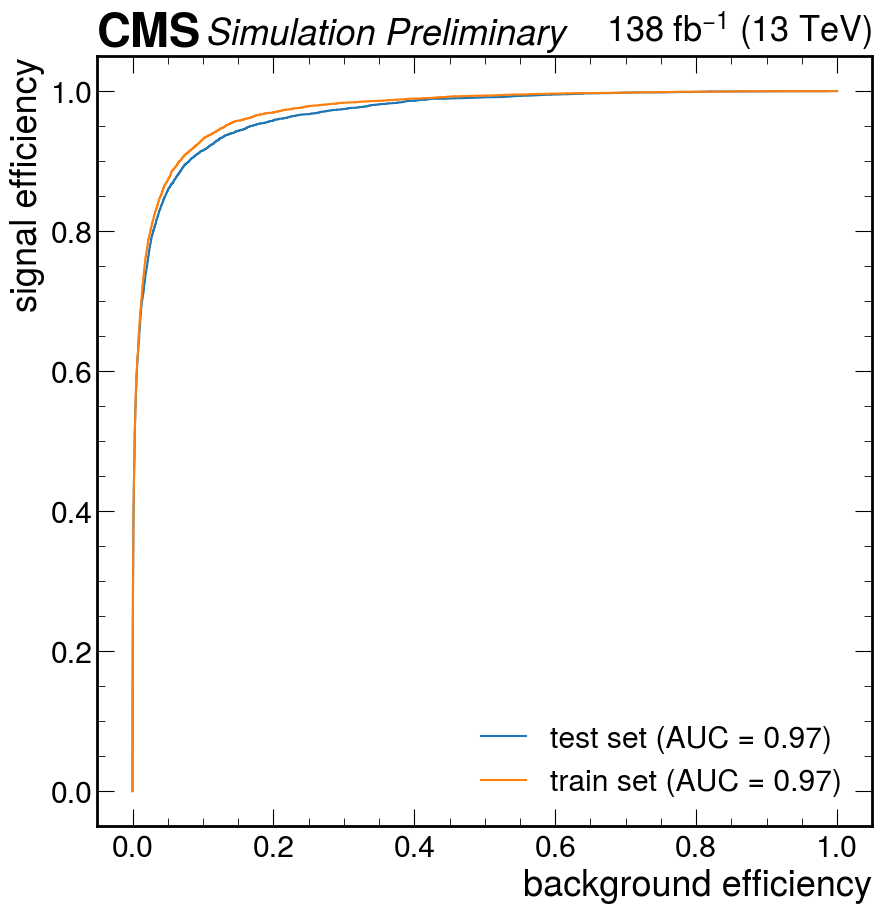

In [32]:
fig, axes = plt.subplots()

# Test ROC Curve
fpr, tpr, thresh = roc_curve(test_df.is_signal, preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

# Train ROC Curve
fpr, tpr, thresh = roc_curve(train_df.is_signal, preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

hep.cms.label("Preliminary", data=False, lumi=138, loc=0, ax=axes)

In [33]:
vbsvvh.df["bdt"] = bst.predict(xgb.DMatrix(vbsvvh.df[features]))

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:xlabel='BDT Score', ylabel='Events'>

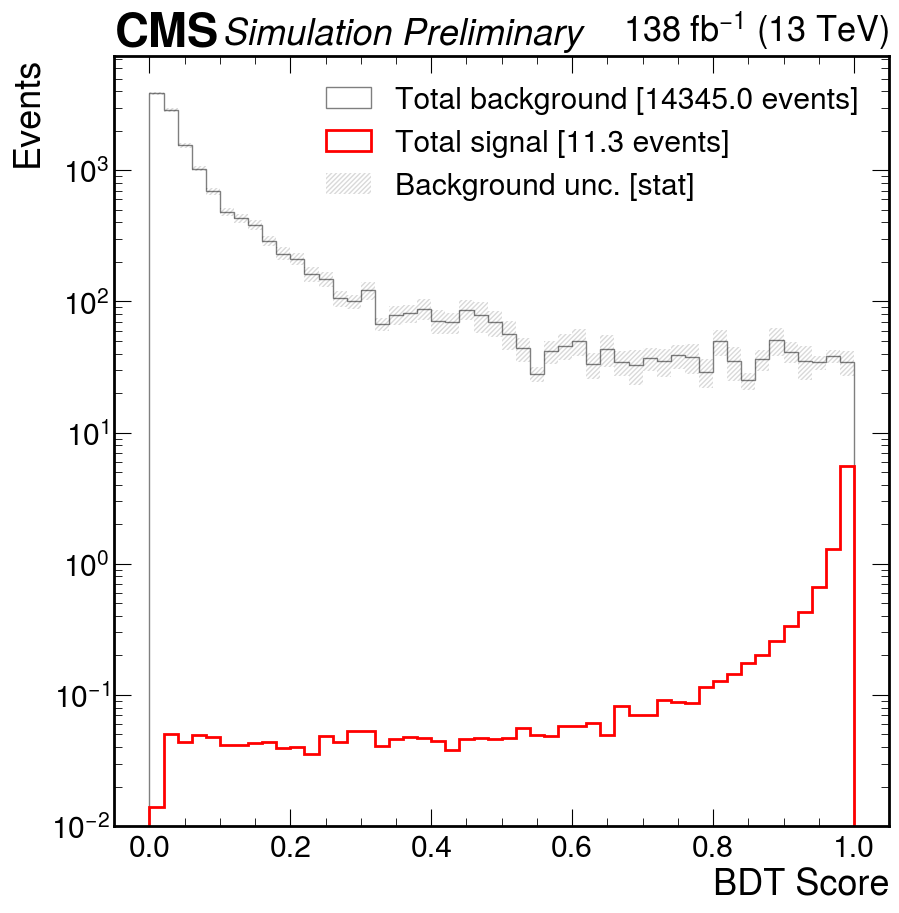

In [34]:
vbsvvh.plot_sig_vs_bkg("bdt", np.linspace(0, 1, 51), x_label="BDT Score", logy=True)

In [35]:
vbsvvh.fom_scan(
    "bdt", [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94], 
    base_selection="M_jj > 500 and abs(deta_jj) > 3", 
    show_raw=True
)

sel,sig,,bkg,,fom
M_jj > 500 and abs(deta_jj) > 3,9.82965083579866,16141,2921.9799519395315,14568,0.1818442091165166
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.8,8.735865660744128,14340,345.7868357177542,1791,0.46978778359669565
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.85,8.493524947879454,13935,265.43457750328236,1421,0.5213258000994517
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.9,8.071238158002863,13224,176.32199146500497,1039,0.6078367037316056
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.91,7.934196414764424,13011,150.76314612024393,948,0.6461827371069464
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.92,7.799025978605238,12785,138.11297150106222,865,0.6636256020914414
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.93,7.6155160599630705,12509,127.63310332042018,766,0.6740896730075872
M_jj > 500 and abs(deta_jj) > 3 and bdt > 0.94,7.420766210427166,12187,104.71810055808182,692,0.7251667309350696


In [36]:
for key, val in params.items():
    print(f"{key},{val}")

objective,binary:logistic
eta,0.01
max_depth,3
verbosity,1
nthread,8
eval_metric,auc
subsample,0.6
alpha,4.0
gamma,2.0
lambda,1.0
min_child_weight,1.0
colsample_bytree,1.0
scale_pos_weight,2546.709716796875


In [37]:
BDTTAG = "mediumPresel_newSignal_onlyVBS"

# Write features list
with open(f"../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_{BDTTAG}_features.txt", "w") as txt_file:
    txt_file.write("\n".join(features))

# Write BDT model
pickle.dump(bst, open(f"../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_{BDTTAG}.pkl", "wb"))
bst.save_model(f"../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_{BDTTAG}.model")
bst.dump_model(
    f"../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_{BDTTAG}.json", 
    f"../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_{BDTTAG}_features.txt"
)

In [38]:
import os
import uproot

old_dir = f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2"
new_dir = old_dir.replace(f"output_{TAG}", f"output_{TAG}_vbs_bdt")
os.makedirs(new_dir, exist_ok=True)


for old_root_file in glob.glob(f"{old_dir}/*.root"):
    file_name = old_root_file.split("/")[-1]
    print(f"Loading {old_root_file}")
    with uproot.open(old_root_file) as old_baby:
        # Copy the existing TTree
        tree = old_baby["tree"].arrays()
        baby_df = old_baby["tree"].arrays(library="pd")

        # Add the new branch to the copy
        tree["vbs_bdt_score"] = bst.predict(xgb.DMatrix(baby_df[features]))

        # Write the updated TTree to a new ROOT file
        new_root_file = f"{new_dir}/{file_name}"
        with uproot.recreate(new_root_file) as new_baby:
            new_baby["tree"] = tree
        
        print(f"Wrote {new_root_file}")

Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/VBSVVH.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/VBSVVH.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/data.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/data.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/TTHad.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/TTHad.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/TTH.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/TTH.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/Bosons.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/Bosons.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/QCD.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/QCD.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/TTW.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/TTW.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/TT1L.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/TT1L.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/SingleTop.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/SingleTop.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/OSVBSWWH.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/OSVBSWWH.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/VBSZZH.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/VBSZZH.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/SSVBSWWH.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/SSVBSWWH.root
Loading ../analysis/studies/vbsvvhjets/output_new_signal/Run2/VBSWZH.root


/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wrote ../analysis/studies/vbsvvhjets/output_new_signal_vbs_bdt/Run2/VBSWZH.root
